In [46]:
import pandas as pd
import numpy as np
import os
import json
import statistics
import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from dateutil import parser
import datetime
import matplotlib.pyplot as plt
from dateutil.tz import tzutc
import math

In [2]:
d = "./result_long"

dirs_to_analyze = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o)) and "\\experiment" in os.path.join(d, o)]


In [89]:
rowsList = []
numjobs = []
batches = []

for curdir in dirs_to_analyze:
    row = {}    
    try:
        time_summary = json.load(open(curdir + "/summary.json"))
        service_times = []
        process_times = []
        wait_times = []
        
        start_time = parser.parse(time_summary["start"])
        end_time = parser.parse(time_summary["shutdown"])

        time_offset = datetime.timedelta(minutes=30)
        batch_start_time = start_time + time_offset

        batch_start_seconds = (batch_start_time-datetime.datetime(1970,1,1).replace(tzinfo=tzutc())).total_seconds()
        end_seconds = (end_time.replace(tzinfo=None)-datetime.datetime(1970,1,1)).total_seconds()

        num_batches = 4

        batch_delta = (end_seconds - batch_start_seconds) / float(num_batches)


        batch_num = 0
        batch_jobs = []

        for batch_start in np.arange(batch_start_seconds, end_seconds, batch_delta):
            batch_num = batch_num + 1
#             print("Batch ", batch_num)
#             print(batch_start, " - ", batch_start + batch_delta)
            new_batch_jobs = []

            i = -1
            for job in time_summary['jobs']:
                i = i + 1
                if (float(job['end']) >= batch_start) & (float(job['end']) < batch_start + batch_delta):
                    new_batch_jobs.append(i)

#             print("Num jobs", len(new_batch_jobs))
            numjobs.append(len(new_batch_jobs))
            batch_jobs.append(new_batch_jobs)
        
        batches.append(batch_jobs)
        
        row['Num generated'] = time_summary['jobCount']

        for job in time_summary['jobs']:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)

        row['Service Time mean'] = statistics.mean(service_times)
        row['Service Time std'] = statistics.stdev(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Process Time std'] = statistics.stdev(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Waiting Time std'] = statistics.stdev(wait_times)
    except Exception as e:
        print("Error parsing time summary for folder " + curdir)
        print(e)
        
    try:
        config = json.load(open(curdir + "/config.json"))
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])

    except Exception as e:
        print("Error parsing config for folder " + curdir)
        print(e)
        
    try:
        accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
        row['Num finished'] = accuracy["top1"].count()
        row['Top 1 mean'] = accuracy["top1"].mean()
        row['Top 1 std'] = accuracy["top1"].std()
        row['Top 5 mean'] = accuracy["top5"].mean()
        row['Top 5 std'] = accuracy["top5"].std()
        row['loss mean'] = accuracy["loss"].mean()
        row['loss std'] = accuracy["loss"].std()
        row['lossnum'] = accuracy["lossnum"].mean()
    except Exception as e:
        print("Error parsing accuracy for folder " + curdir)
        print(e)
        
    
    rowsList.append(row) 
    
analysis_old = pd.DataFrame(rowsList)
# analysis_old

In [90]:
mu = 0.90
sigma = 0.05
def z_score(x, mu, sig):
    return (x-mu)/sig

In [140]:
## Creating batches
rowsList = []
numjobs = []

new_df = pd.DataFrame(columns=analysis.columns)
i = -1
for curdir in dirs_to_analyze:
#     print(curdir)
    i = i + 1
    time_summary = json.load(open(curdir + "/summary.json"))
    config = json.load(open(curdir + "/config.json"))
    accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
    accuracy["Experiment"] = [int(x.split(".")[0]) for x in accuracy.index]

    experiment_batches = batches[i]
    batch_num = 0
    for curbat in experiment_batches:
        batch_num = batch_num + 1
        if len(curbat) == 0:
            continue
        row = {}
        
        service_times = []
        process_times = []
        wait_times = []
        batch_summary = time_summary['jobs'][min(curbat):max(curbat)+1]
        for job in batch_summary:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)
        row['Batch Number'] = batch_num
        row['Experiment Number'] = i
        row['Service Time mean'] = statistics.mean(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])
        
        
        row['Experiment Name'] = str(row['Batch Size']) + " - " + str(row['Max Epochs']) + " - " + str(row['Learning Rate'])
        
        batch_accuracy = accuracy[accuracy["Experiment"].isin(curbat)]
        row['Num finished'] = batch_accuracy["top1"].count()
        row['Top 1 mean'] = batch_accuracy["top1"].mean()
        row['Top 1 std'] = batch_accuracy["top1"].std()
        row['Top 5 mean'] = batch_accuracy["top5"].mean()
        row['Top 5 std'] = batch_accuracy["top5"].std()
        row['loss mean'] = batch_accuracy["loss"].mean()
        row['loss std'] = batch_accuracy["loss"].std()
        row['lossnum'] = batch_accuracy["lossnum"].mean()
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['Final1'] = math.e**row['Zscore1'] /  row['Service Time mean']
        row['Final5'] = math.e**row['Zscore5'] / row['Service Time mean']
        
        rowsList.append(row) 
    
analysis_batch = pd.DataFrame(rowsList)
analysis_batch

,Batch Number,Experiment Number,Service Time mean,Process Time mean,Waiting Time mean,Executor Memory,Batch Size,Max Epochs,Learning Rate,Nodes,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Zscore1,Zscore5,Final1,Final5
0,1,0,523.205719,523.205645,0.000074,1,128,10,0.005,1,...,0.008061,0.995400,0.000283,0.320982,0.010210,157.0,0.278000,1.908000,0.002524,0.012881
1,2,0,521.276814,521.276731,0.000083,1,128,10,0.005,1,...,0.002553,0.996533,0.000473,0.306239,0.004603,157.0,0.356000,1.930667,0.002739,0.013225
2,3,0,789.010816,529.829070,259.181745,1,128,10,0.005,1,...,0.005302,0.995680,0.000517,0.314583,0.016267,157.0,0.327600,1.913600,0.001759,0.008590
3,4,0,1449.641481,545.099980,904.541502,1,128,10,0.005,1,...,0.003976,0.996167,0.000712,0.305998,0.015216,157.0,0.388333,1.923333,0.001017,0.004721
4,1,1,1817.286394,919.909957,897.376438,1,128,20,0.005,1,...,0.002304,0.997920,0.000356,0.221667,0.008146,157.0,0.736400,1.958400,0.001149,0.003900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,4,25,12157.408238,1561.927681,10595.480557,1,64,20,0.020,1,...,0.000757,0.999867,0.000058,0.069822,0.001971,313.0,1.586666,1.997333,0.000402,0.000606
100,1,26,923.621292,484.908643,438.712648,1,64,5,0.020,1,...,0.002140,0.999500,0.000115,0.114563,0.005581,313.0,1.326857,1.990000,0.004081,0.007920
101,2,26,431.771805,431.771597,0.000208,1,64,5,0.020,1,...,0.002258,0.999650,0.000129,0.117241,0.006077,313.0,1.301000,1.993000,0.008507,0.016994
102,3,26,460.051439,460.051366,0.000073,1,64,5,0.020,1,...,NaN,0.999600,NaN,0.125618,NaN,313.0,1.248000,1.992000,0.007572,0.015933


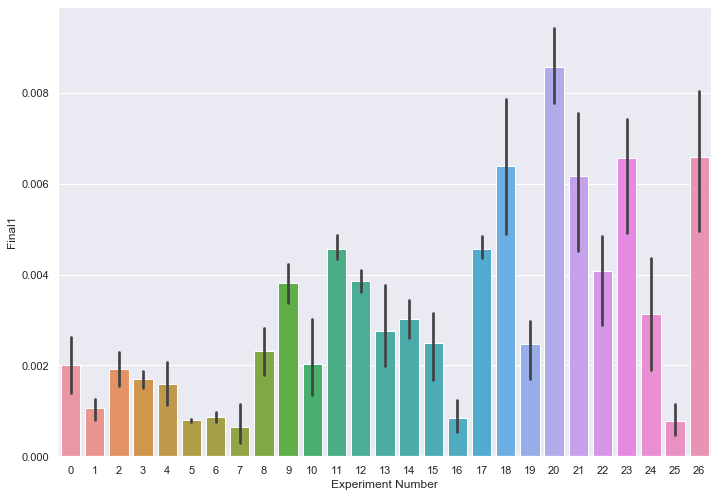

In [141]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x="Experiment Number", y="Final1", data=analysis_batch, ci=95)

(0.8, 1.0)

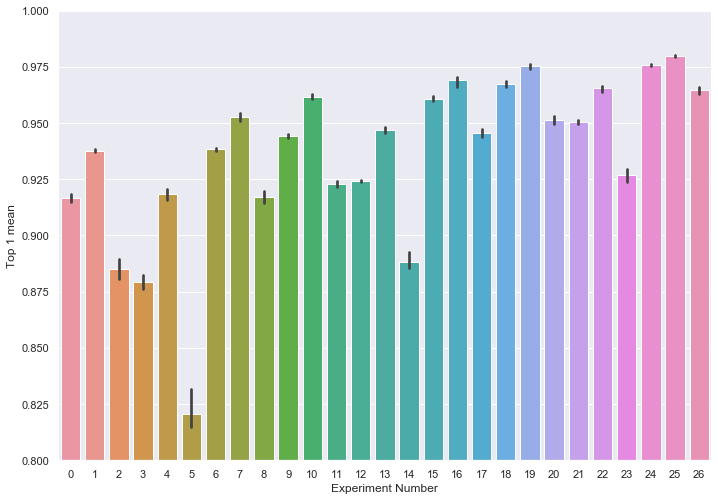

In [142]:
bp = sns.barplot(x="Experiment Number", y="Top 1 mean", data=analysis_batch, ci=95)
axes = bp.axes
axes.set_ylim(0.8,1.0)

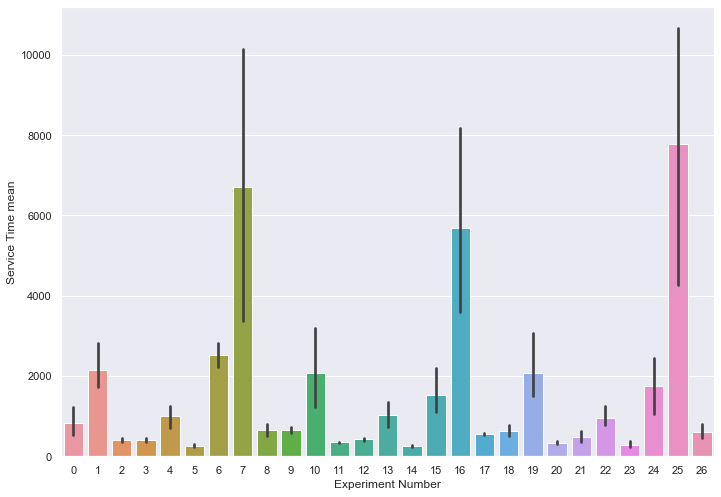

In [143]:
sns.barplot(x="Experiment Number", y="Service Time mean", data=analysis_batch, ci=95)


In [121]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Top 1 mean", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Top 1 mean": "Acc", "Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('Acc ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 26, 77) =  609.957, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Acc   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     610.0
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           9.05e-79
Time:                        15:43:14   Log-Likelihood:                 481.71
No. Observations:                 104   AIC:                            -909.4
Df Residuals:                      77   BIC:                            -838.0
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.9169      0.001    669.726      0.000       0.914       0.920
C(BS)[T.128]                              -0.0317      0.002    -16.385      0.000      -0.036      -0.028
C(BS)[T.256]                              -0.0964      0.002    -46.086      0.000      -0.101      -0.092
C(ME)[T.10]                                0.0214      0.002     11.045      0.000       0.018       0.025
C(ME)[T.20]                                0.0358      0.002     18.484      0.000       0.032       0.040
C(LR)[T.0.01]                              0.0287      0.002     14.826      0.000       0.025       0.033
C(LR)[T.0.02]                              0.0478      0.002     24.705      0.000       0.044       0.052
C(BS)[T.128]:C(ME)[T.10]                   0.0103      0.003      3.755      0.000       0.005       0.016
C(BS)[T.256]:C(ME)[T.10]                   0.0373      0.003     13.088      0.000       0.032       0.043
C(BS)[T.128]:C(ME)[T.20]                   0.0168      0.003      6.120      0.000       0.011       0.022
C(BS)[T.256]:C(ME)[T.20]                   0.0619      0.003     21.720      0.000       0.056       0.068
C(BS)[T.128]:C(LR)[T.0.01]                 0.0089      0.003      3.238      0.002       0.003       0.014
C(BS)[T.256]:C(LR)[T.0.01]                 0.0390      0.003     13.182      0.000       0.033       0.045
C(BS)[T.128]:C(LR)[T.0.02]                 0.0184      0.003      6.709      0.000       0.013       0.024
C(BS)[T.256]:C(LR)[T.0.02]                 0.0586      0.003     19.828      0.000       0.053       0.065
C(ME)[T.10]:C(LR)[T.0.01]                 -0.0062      0.003     -2.271      0.026      -0.012      -0.001
C(ME)[T.20]:C(LR)[T.0.01]                 -0.0124      0.003     -4.532      0.000      -0.018      -0.007
C(ME)[T.10]:C(LR)[T.0.02]                 -0.0103      0.003     -3.749      0.000      -0.016      -0.005
C(ME)[T.20]:C(LR)[T.0.02]                 -0.0208      0.003     -7.601      0.000      -0.026      -0.015
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.01]    -0.0040      0.004     -1.030      0.306      -0.012       0.004
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.01]    -0.0165      0.004     -4.100      0.000      -0.025      -0.008
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.01]    -0.0011      0.004     -0.290      0.773      -0.009       0.007
C(BS)[T.256]:C(ME)[T.20]:C(LR)[T.0.01]    -0.0265      0.004     -6.573      0.000      -0.035      -0.018
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.02]    -0.0055      0.004     -1.416      0.161      -0.013       0.002
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.02]    -0.0248      0.004     -6.154      0.000      -0.033      -0.017
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.02]    -0.0079      0.004     -2.051      0.044     

,sum_sq,df,F,PR(>F),Var
C(BS),0.030007,2.0,2001.051009,4.199108e-67,24.46%
C(ME),0.029644,2.0,1976.798820,6.655325e-67,24.17%
C(LR),0.049642,2.0,3310.408013,2.145182e-75,40.47%
C(BS):C(ME),0.004577,4.0,152.611336,8.762208e-36,3.73%
C(BS):C(LR),0.003975,4.0,132.538809,1.028364e-33,3.24%
C(ME):C(LR),0.003433,4.0,114.459204,1.331388e-31,2.80%
C(BS):C(ME):C(LR),0.000808,8.0,13.478668,5.306369e-12,0.66%
Residual,0.000577,77.0,NaN,NaN,0.47%


In [122]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Final1", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('Final1 ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 26, 77) =  7.490, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Final1   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     7.490
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           2.38e-12
Time:                        15:43:37   Log-Likelihood:                -751.62
No. Observations:                 104   AIC:                             1557.
Df Residuals:                      77   BIC:                             1629.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                458.1306    193.504      2.368      0.020      72.814     843.447
C(BS)[T.128]                              86.8187    273.656      0.317      0.752    -458.101     631.738
C(BS)[T.256]                             809.1207    295.583      2.737      0.008     220.540    1397.701
C(ME)[T.10]                              711.0830    273.656      2.598      0.011     166.164    1256.002
C(ME)[T.20]                             1901.8838    273.656      6.950      0.000    1356.964    2446.803
C(LR)[T.0.01]                           -238.1714    273.656     -0.870      0.387    -783.091     306.748
C(LR)[T.0.02]                           -294.2860    273.656     -1.075      0.286    -839.205     250.633
C(BS)[T.128]:C(ME)[T.10]                -677.7597    387.009     -1.751      0.084   -1448.392      92.873
C(BS)[T.256]:C(ME)[T.10]               -1379.8148    402.811     -3.425      0.001   -2181.914    -577.715
C(BS)[T.128]:C(ME)[T.20]               -1439.5558    387.009     -3.720      0.000   -2210.188    -668.923
C(BS)[T.256]:C(ME)[T.20]               -2476.7793    402.811     -6.149      0.000   -3278.879   -1674.680
C(BS)[T.128]:C(LR)[T.0.01]               -87.2415    387.009     -0.225      0.822    -857.874     683.391
C(BS)[T.256]:C(LR)[T.0.01]              -694.8459    418.017     -1.662      0.101   -1527.224     137.532
C(BS)[T.128]:C(LR)[T.0.02]              -132.7722    387.009     -0.343      0.732    -903.405     637.860
C(BS)[T.256]:C(LR)[T.0.02]              -814.8232    418.017     -1.949      0.055   -1647.201      17.555
C(ME)[T.10]:C(LR)[T.0.01]               -479.3612    387.009     -1.239      0.219   -1249.994     291.271
C(ME)[T.20]:C(LR)[T.0.01]               -711.4421    387.009     -1.838      0.070   -1482.075      59.190
C(ME)[T.10]:C(LR)[T.0.02]               -489.6250    387.009     -1.265      0.210   -1260.257     281.007
C(ME)[T.20]:C(LR)[T.0.02]               -487.6008    387.009     -1.260      0.212   -1258.233     283.032
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.01]   491.9170    547.313      0.899      0.372    -597.922    1581.756
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.01]  1073.6022    569.661      1.885      0.063     -60.738    2207.942
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.01]   630.7764    547.313      1.152      0.253    -459.063    1720.615
C(BS)[T.256]:C(ME)[T.20]:C(LR)[T.0.01]  1352.0265    569.661      2.373      0.020     217.686    2486.367
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.02]   504.2093    547.313      0.921      0.360    -585.630    1594.048
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.02]  1173.3672    569.661      2.060      0.043      39.027    2307.707
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.02]   364.1587    547.313      0.665      0.508    -

,sum_sq,df,F,PR(>F),Var
C(BS),5.233192e+06,2.0,17.470108,5.545317e-07,12.81%
C(ME),7.929367e+06,2.0,26.470821,1.780662e-09,19.41%
C(LR),6.539990e+06,2.0,21.832626,3.083026e-08,16.01%
C(BS):C(ME),8.084596e+06,4.0,13.494513,2.211938e-08,19.79%
C(BS):C(LR),2.822829e+05,4.0,0.471176,7.567187e-01,0.69%
C(ME):C(LR),3.639694e+04,4.0,0.060752,9.930413e-01,0.09%
C(BS):C(ME):C(LR),1.212785e+06,8.0,1.012168,4.340946e-01,2.97%
Residual,1.153272e+07,77.0,NaN,NaN,28.23%


In [124]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Process Time mean", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Process Time mean" : "PT","Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('PT ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 26, 77) =  681.094, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PT   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     681.1
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           1.33e-80
Time:                        15:43:59   Log-Likelihood:                -486.80
No. Observations:                 104   AIC:                             1028.
Df Residuals:                      77   BIC:                             1099.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                475.7682     15.165     31.372      0.000     445.571     505.966
C(BS)[T.128]                            -173.7309     21.447     -8.101      0.000    -216.437    -131.025
C(BS)[T.256]                            -248.2050     23.165    -10.715      0.000    -294.333    -202.077
C(ME)[T.10]                              355.0837     21.447     16.557      0.000     312.378     397.790
C(ME)[T.20]                             1131.4608     21.447     52.757      0.000    1088.755    1174.167
C(LR)[T.0.01]                              9.0437     21.447      0.422      0.674     -33.662      51.750
C(LR)[T.0.02]                            -12.8867     21.447     -0.601      0.550     -55.593      29.819
C(BS)[T.128]:C(ME)[T.10]                -127.2682     30.330     -4.196      0.000    -187.664     -66.873
C(BS)[T.256]:C(ME)[T.10]                -214.4607     31.569     -6.793      0.000    -277.322    -151.599
C(BS)[T.128]:C(ME)[T.20]                -460.6970     30.330    -15.189      0.000    -521.092    -400.302
C(BS)[T.256]:C(ME)[T.20]                -699.8948     31.569    -22.170      0.000    -762.756    -637.033
C(BS)[T.128]:C(LR)[T.0.01]                -5.0552     30.330     -0.167      0.868     -65.451      55.340
C(BS)[T.256]:C(LR)[T.0.01]               -12.2243     32.760     -0.373      0.710     -77.459      53.010
C(BS)[T.128]:C(LR)[T.0.02]                 8.1133     30.330      0.267      0.790     -52.282      68.509
C(BS)[T.256]:C(LR)[T.0.02]                -0.4231     32.760     -0.013      0.990     -65.658      64.811
C(ME)[T.10]:C(LR)[T.0.01]                  6.4772     30.330      0.214      0.831     -53.918      66.873
C(ME)[T.20]:C(LR)[T.0.01]                -33.5131     30.330     -1.105      0.273     -93.908      26.882
C(ME)[T.10]:C(LR)[T.0.02]                -31.7302     30.330     -1.046      0.299     -92.126      28.665
C(ME)[T.20]:C(LR)[T.0.02]                -70.7597     30.330     -2.333      0.022    -131.155     -10.364
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.01]    10.8904     42.894      0.254      0.800     -74.522      96.302
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.01]     9.7222     44.645      0.218      0.828     -79.177      98.622
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.01]    22.8803     42.894      0.533      0.595     -62.532     108.292
C(BS)[T.256]:C(ME)[T.20]:C(LR)[T.0.01]    30.7793     44.645      0.689      0.493     -58.120     119.679
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.02]    25.2467     42.894      0.589      0.558     -60.165     110.659
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.02]    24.7399     44.645      0.554      0.581     -64.160     113.639
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.02]    43.5402     42.894      1.015      0.313     

,sum_sq,df,F,PR(>F),Var
C(BS),5.356690e+06,2.0,2911.471505,2.833035e-73,32.18%
C(ME),9.809989e+06,2.0,5331.931061,2.721986e-83,58.94%
C(LR),1.946284e+04,2.0,10.578457,8.728477e-05,0.12%
C(BS):C(ME),1.374395e+06,4.0,373.505925,1.419697e-49,8.26%
C(BS):C(LR),4.208047e+03,4.0,1.143580,3.424690e-01,0.03%
C(ME):C(LR),5.993984e+03,4.0,1.628927,1.755005e-01,0.04%
C(BS):C(ME):C(LR),1.994102e+03,8.0,0.270959,9.735154e-01,0.01%
Residual,7.083448e+04,77.0,NaN,NaN,0.43%


In [22]:
# Process time results:
print("Max avg process time: ", analysis["Process Time mean"].max())
print("Min avg process time: ", analysis["Process Time mean"].min())
print("Mean avg process time: ", analysis["Process Time mean"].mean())

print("Min mu: ", "%.7f" % (1/analysis["Process Time mean"].max()))
print("Max mu: ", "%.7f" % (1/analysis["Process Time mean"].min()))
print("Mean mu: ", "%.7f" % (1/analysis["Process Time mean"].mean()))


Max avg process time:  1607.9454131343148
Min avg process time:  221.33136041959128
Mean avg process time:  661.2832442589637
Min mu:  0.0006219
Max mu:  0.0045181
Mean mu:  0.0015122


In [23]:
important_cols=[x for x in analysis.columns if "Top 1" in x]
important_cols.extend([x for x in analysis.columns if "Time" in x])


In [45]:
display(rp.summary_cont(analysis[[x for x in important_cols if "Process" in x]].groupby(analysis["Batch Size"])))

Process Time mean                                                  \
                           N        Mean          SD          SE   95% Conf.   
Batch Size                                                                     
64                         9  960.677732  487.255026  162.418342  642.337782   
128                        9  605.408268  288.822487   96.274162  416.710910   
256                        9  417.763732  189.360230   63.120077  294.048382   

                        Process Time std                                   \
               Interval                N       Mean         SD         SE   
Batch Size                                                                  
64          1279.017683                9  81.451446  31.191834  10.397278   
128          794.105627                9  51.786413  17.610607   5.870202   
256          541.479082                9  34.397215   9.715132   3.238377   

                                   
            95% Conf.    Interval  
Batch Size                         
64          61.072781  101.830111  
128         40.280816   63.292009  
256         28.049995   40.744434

In [26]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124
24,22,1970.924572,978.695520,793.006613,86.758666,1177.917959,1012.168823,1,64,10,...,0.001787,0.999842,0.000130,0.080110,0.004492,313.0,173.988553,2069.716684,15198.656356,0.000495
19,20,2131.789124,1059.114402,940.633077,74.634033,1191.156046,1069.387943,1,128,20,...,0.001554,0.999718,0.000167,0.082534,0.004806,157.0,208.579016,2241.079798,18962.416706,0.000458
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,141.923934,769.045701,4989.089055,0.001346
22,19,920.973086,395.503711,638.995857,49.093591,281.977229,385.722739,1,256,20,...,0.002365,0.999528,0.000190,0.115465,0.007051,79.0,171.040099,987.148771,6624.322798,0.001049
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,125.921952,710.837298,5645.764456,0.001457
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
15,17,1580.519892,808.741149,843.792611,66.610356,736.727281,817.195708,1,64,10,...,0.002772,0.999294,0.000267,0.133583,0.008410,313.0,249.767834,1711.874140,12998.461261,0.000608
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145


In [27]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124
24,22,1970.924572,978.695520,793.006613,86.758666,1177.917959,1012.168823,1,64,10,...,0.001787,0.999842,0.000130,0.080110,0.004492,313.0,173.988553,2069.716684,15198.656356,0.000495
19,20,2131.789124,1059.114402,940.633077,74.634033,1191.156046,1069.387943,1,128,20,...,0.001554,0.999718,0.000167,0.082534,0.004806,157.0,208.579016,2241.079798,18962.416706,0.000458
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,141.923934,769.045701,4989.089055,0.001346
22,19,920.973086,395.503711,638.995857,49.093591,281.977229,385.722739,1,256,20,...,0.002365,0.999528,0.000190,0.115465,0.007051,79.0,171.040099,987.148771,6624.322798,0.001049
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,125.921952,710.837298,5645.764456,0.001457
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
15,17,1580.519892,808.741149,843.792611,66.610356,736.727281,817.195708,1,64,10,...,0.002772,0.999294,0.000267,0.133583,0.008410,313.0,249.767834,1711.874140,12998.461261,0.000608
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145


In [28]:


final_score = analysis["Top 1 mean"].apply(lambda x: math.e**z_score(x, mu, sigma))
final_score5 = analysis["Top 5 mean"].apply(lambda x: math.e**z_score(x, mu, sigma))


In [29]:
## Service time / Zscore
analysis["Service/Zscore"] = analysis['Service Time mean']/final_score
display(analysis.sort_values(by=['Service/Zscore']).head())
display(analysis.sort_values(by=['Service/Zscore']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,117.459190,364.210932,1209.722237,0.002885
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,165.881657,336.380612,1966.768360,0.003204
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,179.498947,710.837298,5645.764456,0.001457
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,191.654032,769.045701,4989.089055,0.001346
21,26,531.066340,194.083426,354.058982,25.572411,177.007358,192.073569,1,256,10,...,0.003364,0.998816,0.000297,0.169185,0.010566,79.0,192.144376,587.409819,3367.472647,0.001790


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,1099.771494,2671.895625,11396.212171,0.000399
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1267.110711,407.854667,1571.462835,0.002976
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,1457.726840,6233.101412,41286.620955,0.000165
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,1606.145640,8232.639886,72687.867266,0.000124
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,2292.430978,7251.252080,72027.396118,0.000145


In [30]:
## Service time / Zscore5
analysis["Service/Zscore"] = analysis['Service Time mean']/final_score5
display(analysis.sort_values(by=['Service/Zscore']).head())
display(analysis.sort_values(by=['Service/Zscore']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,41.643122,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,41.750820,336.380612,1966.768360,0.003204
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,45.683539,364.210932,1209.722237,0.002885
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,50.188212,407.854667,1571.462835,0.002976
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,52.505570,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,330.156456,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,332.663141,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,796.956459,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,909.930303,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,1072.690955,8232.639886,72687.867266,0.000124


In [31]:
## Service time / Zscore
analysis["Service/Zscore"] = analysis['Process Time mean']/final_score
display(analysis.sort_values(by=['Service/Zscore']).head())
display(analysis.sort_values(by=['Service/Zscore']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,125.921952,710.837298,5645.764456,0.001457
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
21,26,531.066340,194.083426,354.058982,25.572411,177.007358,192.073569,1,256,10,...,0.003364,0.998816,0.000297,0.169185,0.010566,79.0,128.101589,587.409819,3367.472647,0.001790
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,141.923934,769.045701,4989.089055,0.001346


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
1,21,2068.116207,940.238236,979.102109,71.374752,1089.014098,972.418779,1,128,20,...,0.003374,0.997989,0.000327,0.221215,0.010395,157.0,462.135511,2352.861459,19475.325769,0.000453
4,20,1004.807165,369.385723,669.282307,40.808168,335.524858,371.995803,1,256,20,...,0.004882,0.996078,0.000634,0.306919,0.018671,79.0,465.285168,1191.870778,7195.448461,0.000914
3,17,416.221998,121.978029,374.529568,35.783015,41.692430,112.565025,1,256,10,...,0.010511,0.991550,0.001534,0.475815,0.027349,79.0,540.054896,535.406144,1789.052134,0.002118
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976


In [32]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,196.461759,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,393.350962,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124


In [33]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,196.461759,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,393.350962,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124


In [34]:
## LISAS score, lower is better

analysis["LISAS"] = analysis['Service Time mean'] + analysis["Service Time std"] / analysis["Top 1 std"] * (1-analysis["Top 1 mean"])
display(analysis.sort_values(by=['LISAS']).head())
display(analysis.sort_values(by=['LISAS']).tail())


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
12,20,416.951840,86.902843,381.071232,30.572190,35.880608,83.915159,1,256,10,...,0.005335,0.996463,0.000713,0.279921,0.016276,79.0,233.970915,487.950661,1648.612133,0.002217
3,17,416.221998,121.978029,374.529568,35.783015,41.692430,112.565025,1,256,10,...,0.010511,0.991550,0.001534,0.475815,0.027349,79.0,540.054896,535.406144,1789.052134,0.002118


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
1,21,2068.116207,940.238236,979.102109,71.374752,1089.014098,972.418779,1,128,20,...,0.003374,0.997989,0.000327,0.221215,0.010395,157.0,462.135511,2352.861459,19475.325769,0.000453
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124


In [35]:
## Adapted RCS
c = analysis["Num finished"] * analysis["Top 1 mean"]
sumRT = analysis["Num finished"] * analysis["Service Time mean"]
analysis["RCS"] = c / sumRT
display(analysis.sort_values(by=['RCS'], ascending=False).head())
display(analysis.sort_values(by=['RCS'], ascending=False).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,196.461759,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,393.350962,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124
